# Analyzing Microscopy Images with PyTorch and Dask

Using a neural network to classify images is an attractive proposition, but getting set up to do it may seem like a challenge. In many cases, especially in research, it can be difficult and expensive to get enough labelled data to train a neural network from scratch. One solution is to use a network that has already been trained on a larger data set as the basis for your neural network, an approach known as 'transfer learning'. The idea is to take advantage of the information embedded in the pre-trained network so that you need far less data to train your own network.

Once you've trained a neural network to classify your images, you'll probably want to use it to analyze lots of data&mdash;if not, you might be better off just having an expert do the analysis. You can run distributed predictions with [Dask](https://dask.org) and easily shift the workload to a remote cluster using [Coiled Cloud](https://coiled.io/cloud/). With a [personal account](https://cloud.coiled.io/signup) on Coiled Cloud, you can run clusters with up to 100 cores for free now.

In this post, you'll get an overview over transfer learning and an explanation of how to run distributed predictions with Dask and Coiled. We'll be analyzing microscopy images to determine whether they show normal cells or leukemic blast cells. The images are from 118 patients who were either healthy or had [acute lymphoblastic leukemia](https://en.wikipedia.org/wiki/Acute_lymphoblastic_leukemia) (ALL), which is the most common childhood cancer and the leading cause of cancer-related deaths among children. ALL can be treated with chemotherapy, but identifying ALL cells under the microscope can be challenging. A reliable, high-throughput system for scoring microscopy images could be used to distinguish cases that are almost certainly positive or negative from those that need further analysis, such as immunological assays or expert review.

This post draws heavily on the [*Batch Prediction with PyTorch*](https://examples.dask.org/machine-learning/torch-prediction.html) tutorial from Dask, which in turn builds on the [*Transfer Learning for Computer Vision*](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) tutorial from PyTorch.

## Setup

The analysis relies on a variety of Python libraries. If you have `conda` installed, you can get set up by downloading this [environment file](http://sedeer.elshowk.com/environment_pytorch-example.yml) and running:
```
$ conda env create -f environment_pytorch-example.yml
$ conda activate coiled-pytorch
```

This environment includes `coiled`. If you haven't already set up Coiled, connect it to your account by running:
```
$ coiled login
```
and following the instructions to provide your token.

Once everything is installed, turn on inline plotting so you can visualize the model's output:

In [1]:
%matplotlib inline

## Data

For this example analysis, we're going to download a subset of the data. Though this post explains how to run the image analysis on Coiled Cloud, we're going to run it locally on a small data set rather than remotely on a larger data set from cloud storage. We'll be using a randomly selected set of images from this [acute lymphoblastic leukemia dataset](https://www.kaggle.com/andrewmvd/leukemia-classification)[1] which we download into `leukemia_data` _([download our subset of data here](https://drive.google.com/file/d/1HXLpgMpv96HtN7h8GJ-3UAOWYZlAneah/view?usp=sharing))_. The images are divided into training and validation sets (`train` and `val` folders) which will be used to retrain the model. Note that there are only 120 training images and 75 validation images&mdash;far fewer than would be needed to train a neural network from scratch!

If you'd like to try this with your own data instead, create the same folder structure with your images and change `data_dir` in `helper_functions` to point to that folder. You can do this locally with about the same number of images and then use the model to train images from a larger data set remotely.

## Transfer learning 

There are several approaches to transfer learning. The one we'll be using here is to retrain the final layer of a trained neural network so it classfies images into the categories we're interested in. We'll be using [ResNet18](https://arxiv.org/abs/1512.03385), a neural network trained on the ImageNet data set. 

The idea is to take advantage of the fact that ResNet18 can extract useful features from images&mdash;things like edges and shapes&mdash;but retrain its final layer to classify images into the two categories we're interested in (leukemia vs. healthy cells) rather than the 1,000 categories it was originally trained to recognize. (If you want to read more about transfer learning or learn about the other approaches, have a look at these [course notes](https://cs231n.github.io/transfer-learning/).)

To carry out the transfer learning, we're going to use a few functions from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) that we've put into `helper_functions`:

In [3]:
from helper_functions import (imshow, train_model, visualize_model,
                             dataloaders, class_names, finetune_model)

The transfer learning is carried out by `finetune_model`. The details of how transfer learning works aren't the focus on this post, but we'll go over it briefly. For a more thorough explanation, have a look at the PyTorch tutorial (in particular [this section](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor)).

The first thing the function does is load the pre-trained ResNet18 model from PyTorch:
```python
    model_ft = models.resnet18(pretrained=True)
```
Next, it freezes all of the parameters in the network so they won't be adjusted when we retrain it:
```python
    for param in model_ft.parameters():
        param.requires_grad = False
```

The function then resets the final layer to have the same number of input features but only two outputclasses:
```python
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
```
The remainder of the function trains the model (using the `train_model` helper function). Since every layer except the (new) last layer has been frozen, the last layer is the only one being trained. In other words, we're taking advantage of all of the feature extraction embedded in the earlier layers or ResNet18 but retraining it to recognize the categories we care about.

In [4]:
#Retrain the model
model = finetune_model()

# Move the model back to the CPU
# It might have moved to the GPU during transfer learning, but we'll only be using CPU clusters with Dask/Coiled
if next(model.parameters()).is_cuda: model.cpu()

Epoch 0/3
----------
train Loss: 0.7358 Acc: 0.5458
val Loss: 0.4529 Acc: 0.8067

Epoch 1/3
----------
train Loss: 0.8621 Acc: 0.5542
val Loss: 0.5589 Acc: 0.7000

Epoch 2/3
----------
train Loss: 0.7959 Acc: 0.6333
val Loss: 0.4760 Acc: 0.8067

Epoch 3/3
----------
train Loss: 0.8458 Acc: 0.6125
val Loss: 0.3549 Acc: 0.8400

Training complete in 1m 1s
Best val Acc: 0.840000


(Note that we're only training the model for four epochs in this example to save time. If you want to get better results, try increasing `num_epochs` in the last line of `finetune_model`.)

Let's have a look at the predictions for some images the model hasn't seen before. We're looking at images from the `validation` set, so we know the correct labels for these images but the model wasn't trained on them. This gives us a quick visual overview of how the model performs on new data. Of course, the idea is to eventually use the model to analyze unlabeled images. 

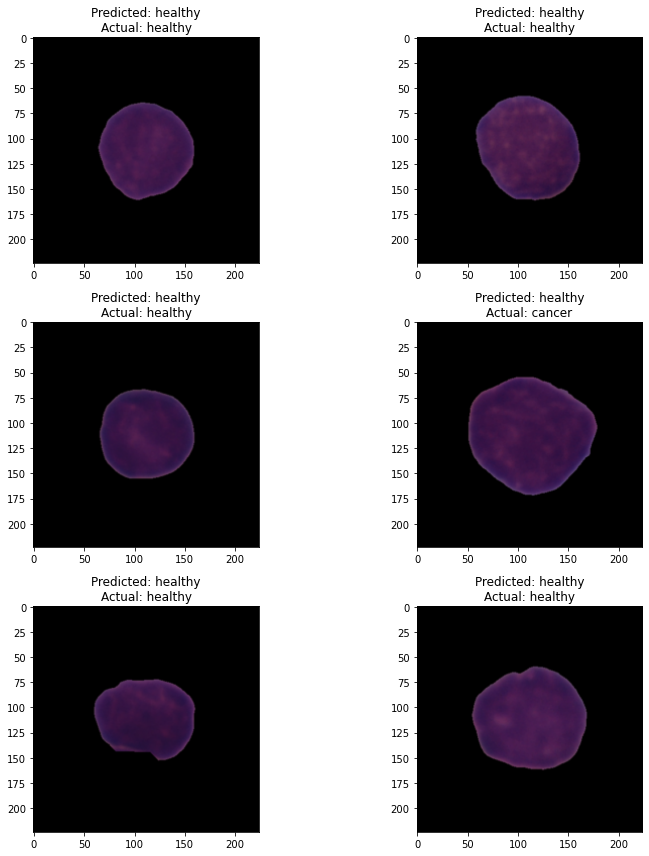

In [5]:
visualize_model(model)

At this point, you've got a model trained to classify your data. If you were only going to analyze a handful of images, you could stop here and use the neural network to classify them. Instead, we're going to show you how to run a distributed analysis on a remote cluster.

## Distributed prediction with Dask and Coiled

The [*Batch Prediction with PyTorch*](https://examples.dask.org/machine-learning/torch-prediction.html) tutorial uses `dask.delayed`. With `dask.delayed`, functions aren't executed immediately but lazily. The execution is deferred, and the dask scheduler builds a task graph connecting all the functions in a computation. This enables the scheduler to identify opportunities for parallel execution and use them to speed up execution. 

We're going to take a different approach here. Instead of building a task graph, we're use going to use Dasks' [Futures interface](https://docs.dask.org/en/latest/futures.html) to run the analysis asynchronously but not lazily. Instead of building a large task graph and then doing the computation, we run the analysis asynchronously in the background and collect the results as they become ready. We still get the benefits of Dask and Coiled&mdash;easy local or remote distributed computing&mdash;but the local Python session never blocks.

Both approaches are effective. The choice between them depends to some extent on your workflow. Futures offers a bit more flexibility so you can adjust your computations and explore different avenues in real-time, which might be preferable for this kind of analysis. If you'd like to use `delayed` instead, compare the code below with the tutorial linked above.

### Dask and Coiled

Since we have the data locally, we're going to use Dask locally instead of creating a cluster on Coiled Cloud:

In [6]:
from distributed import Client

# adjust the paramaters to match your system
client = Client(n_workers=4, threads_per_worker=2)

If you have data that's available remotely, it's quite easy to use a cluster on Coiled Cloud instead:
```python
# Start a cluster on Coiled Cloud
import coiled
cluster = coiled.Cluster(software="sedeer/pytorch-example")

# Connect the client
from distributed import Client
client = Client(cluster)
```
The initiation takes a few minutes to provision resources for the cluster. Note that we're creating a cluster using the `sedeer/pytorch-example` software environment, which was built using the same environment file provided in *Setup*. For more information about software environments and the importance of using the same environment locally and on Coiled Cloud, have a look at the [Coiled docs](https://docs.coiled.io/user_guide/software_environment_local.html).

### Data handling

Aside from a small difference in how the data is loaded, the rest of the code&mdash;the data processing and predictions&mdash;is almost exactly the same whether you're using Dask locally or on Coiled Cloud. We'll write a couple of functions to load the images and transform them into tensors:

In [7]:
import glob
import toolz
import torch
from torchvision import transforms
from PIL import Image
import dask

def load(path, fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img
    
def transform(img):    # This is the same as the 'val' transformation in helper_functions
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)

We're going to use `client.submit` to submit these functions to the Dask scheduler to run on the cluster. This returns a `Future` object which points to the result, which could be completed or `pending`.

We can use `Future` objects as input to `client.submit` without worrying about their status, as we do in the second line of the `for` loop below. Unless we explicitly request a result, everything will run asynchronoulsy with the scheduler tracking dependencies and passing results forward.

In [8]:
tensors = []

for f in glob.glob("leukemia_data/val/*/*.bmp"):
    img = client.submit(load, f)
    tensor = client.submit(transform, img)
    tensors.append(tensor)

tensors[:5]

[<Future: pending, key: transform-0db1e26072a6ba355ac60807987917f7>,
 <Future: pending, key: transform-8dcd5e19b9031fbf3cc390c5118576e9>,
 <Future: pending, key: transform-69e708d5a87a77005cd5f61e0e551a5b>,
 <Future: pending, key: transform-956dc948f701e6ef9f67c3c0c03868c5>,
 <Future: pending, key: transform-27466e56d7e0578bb85d1931667c88e0>]

Note that we loaded the data from the local filesystem (which the local Dask workers have access to). When you're running this on Coiled Cloud, the data needs to be somewhere where the remote workers can access it, such as an Amazon S3 bucket. In that case, we use the same `load` function but point it towards our cloud storage with something like:
```python
import s3fs

fs = s3fs.S3FileSystem(anon=False, key='<Access Key>', secret='<Secret Key>')
```
and then our `for` loop would be:
```python
for f in fs.glob("s3://coiled-data/leukemia_data/val/*/*.bmp"):
    img = client.submit(load, f, fs=fs)
    ...          
```

Either way, the next step is to collect the transformed tensors into batches because the model expects batched input. We'll loop over sequences of up to 10 tensors and collection them in a batch with `torch.stack`:

In [9]:
batches = []

for b in toolz.partition_all(10, tensors):
    batch = client.submit(torch.stack, b)
    batches.append(batch)

Our data is now ready for analysis. Actually, it may not yet be ready, strictly speaking, but we don't have to worry about that. We've got a bunch of futures pointing to the data. They could be pending or finished, and we can go ahead and use them as though the data were ready:

In [10]:
batches[:5]

[<Future: pending, key: stack-a84701c17803fc948def7a0ea5094b40>,
 <Future: pending, key: stack-552d1f69ca44c6e179ddabdac52bfb22>,
 <Future: pending, key: stack-566e4a7e71c0924488438b118e953521>,
 <Future: pending, key: stack-4438e57bf724af3be4d907bcbb159a3e>,
 <Future: pending, key: stack-7d167b8cfe711f7ff706f4944a0520d4>]

Before we continue, we'll delete the futures stored in `tensors`. This isn't crucial, but if we don't do it, Dask will hold on to the futures in case we ever explicitly request the result. We don't want to use up memory to hold intermediate results, especially in cases where we're dealing with large data sets. By deleting it, we let the scheduler know we don't need it and the memory can be cleared as soon as all of the computations depending on it are done.

In [11]:
del tensors

### Classifying the images

The next thing to do is prepare the neural network for use with Dask. To do that, we serialize it with `pickle` and then send it to the cluster with `client.scatter`. This returns a a future pointing to it so the Dask scheduler can figure out how to handle it. This way, the scheduler can use the model future for the computations instead of including the model once per batch.

In [12]:
import cloudpickle

dask.utils.format_bytes(len(cloudpickle.dumps(model)))
modelf = client.scatter(model)

We'll use the following function to make the predictions. It returns the most likely category for each image, which is handy when we're looking at the validation data. Later, we'll use a similar function to return the probability for each category, which would probably be more useful in a real analysis.

In [13]:
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

And with that, we have everything we need to classify the images:

In [14]:
predictions = [client.submit(predict, batch, modelf) for batch in batches]
predictions[:5]

[<Future: pending, key: predict-ddecb46b8b8f1256840c4476e54cca9e>,
 <Future: pending, key: predict-8cfe20dbc9903f870f75c6342875cf9f>,
 <Future: pending, key: predict-b0358a59e76f4b3bd12ffb0907a7bfc0>,
 <Future: pending, key: predict-4d384b98f432fad57d4c0e594f88d1ee>,
 <Future: pending, key: predict-bbae32c961e5bedf3d27a1c07b27a658>]

Again, these are just futures. In this case it's fine to get the output immediately because we're just looking at the (small) validation set. If you were running this on a larger (remote) data set, you might prefer to write the results to cloud storage instead of displaying them.

To get the predictions, we use the `.result` method, which blocks until the future is finished and returns the result. We can do this using a list comprehension or with `client.gather`, which can be faster:

In [15]:
#results = [predictor.result() for predictor in predictions]
results = client.gather(predictions)
results

[array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 1, 1, 1, 0, 1, 1]),
 array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0]),
 array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]),
 array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1])]

We can easily convert the predictions into a more readable format:

In [16]:
classes=["ALL","Nor"]
for rslts in results:
    print([classes[result] for result in rslts])

['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'Nor', 'ALL', 'ALL', 'ALL', 'ALL']
['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL']
['ALL', 'ALL', 'ALL', 'ALL', 'Nor', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL']
['Nor', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'Nor', 'Nor', 'ALL']
['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'Nor', 'Nor']
['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'Nor', 'ALL', 'ALL']
['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'Nor']
['ALL', 'ALL', 'ALL', 'ALL', 'Nor', 'Nor', 'Nor', 'ALL', 'Nor', 'Nor']
['Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'ALL', 'Nor', 'Nor', 'Nor', 'ALL']
['Nor', 'ALL', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor']
['ALL', 'ALL', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'ALL']
['Nor', 'Nor', 'Nor', 'Nor', 'ALL', 'ALL', 'Nor', 'Nor', 'Nor', 'ALL']
['ALL', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor']
['Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor', 'Nor']
['Nor'

That output is a helpful overview of how the model performed on the validation data. We ran predictions on the entire `validation` set, so perfect prediction would produce 75 `ALL`s followed by 75 `Nor`s. 

In a real analysis, you might be more interested in getting the probability score each category for an image. You might use a certain cut-off to identify samples which need further analysis, such as expert review, immunological assays, or maybe even additional machine-learning approaches. It only takes a small change to the `predict` fucction to output probabilities; we just switch to using a `softmax` instead of retrieving the class with the max score:

In [17]:
def predict_probabilities(batch, model):
    with torch.no_grad():
        out = model(batch)
        predicted = torch.nn.functional.softmax(out, dim=1)
        predicted = predicted.numpy()
    return predicted

probabilities = [client.submit(predict_probabilities, batch, modelf) for batch in batches]

At this point, you'd probably want to feed the probabilities into the next step in your workflow/pipeline. Since this is just an example, let's have a look them instead:

In [18]:
result_probs = client.gather(probabilities)
result_probs[:2]

[array([[0.77882165, 0.2211783 ],
        [0.98297405, 0.01702592],
        [0.86754775, 0.13245228],
        [0.8795712 , 0.12042879],
        [0.93017703, 0.06982295],
        [0.3365232 , 0.6634768 ],
        [0.9901371 , 0.00986283],
        [0.55996877, 0.44003126],
        [0.90829384, 0.09170608],
        [0.9493118 , 0.05068822]], dtype=float32),
 array([[0.99760133, 0.0023987 ],
        [0.9412322 , 0.05876777],
        [0.7246055 , 0.2753945 ],
        [0.5671448 , 0.43285516],
        [0.85439664, 0.14560337],
        [0.9352981 , 0.06470188],
        [0.50471824, 0.4952818 ],
        [0.9493237 , 0.05067629],
        [0.5877161 , 0.41228393],
        [0.84607416, 0.15392582]], dtype=float32)]

And finally, we shut down the client when we're done:

In [19]:
client.close()

And with that, you're ready to train an image classifier and run it distributed across a local or remote cluster! Dig further into the leukemia data set&mdash;we only analyzed a small fraction of it here&mdash;or use these tools to analyze your own data. Get hassle-free cloud deployments of Dask clusters for your analyses by clicking below to sign up for a free Coiled Cloud account. Get in touch and let us know how your analyses go&mdash;we'd love to help with any challenges and hear about your successes!

## Footnote

**[1] Citations for dataset:**

__Data citation:__
* Gupta, A., & Gupta, R. (2019). ALL Challenge dataset of ISBI 2019 [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/tcia.2019.dc64i46r

__Publication citations:__
* Shiv Gehlot, Anubha Gupta, and Ritu Gupta, “SDCT-AuxNetθ: DCT Augmented Stain Deconvolutional CNN with Auxiliary Classifier for Cancer Diagnosis,” Medical Image Analysis, Elsevier, vol. 61, pp. 1-15, April 2020, DOI: https://doi.org/10.1016/j.media.2020.101661.

* Shubham Goswami, Suril Mehta, Dhruv Sahrawat, Anubha Gupta and Ritu Gupta, “Heterogeneity Loss to Handle Intersubject and Intrasubject Variability in Cancer", ICLR workshop on Affordable AI in healthcare, 2020. arXiv preprint arXiv:2003.03295.